In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import utils
from os import path
from glob import glob

In [2]:
NEAR_PAIR = (408, 800)
FAR_PAIR = (323, 374)

DATA_HOME = path.expanduser('~/netsci/dataset')

pattern = path.join(DATA_HOME, '*.graphml')
graph_filenames = sorted(glob(pattern))

def load_graph(fpath):
    G = nx.read_graphml(fpath)
    G = nx.convert_node_labels_to_integers(G)
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

# Load the most similar and most different pairs of graphs
Gn1 = load_graph(graph_filenames[NEAR_PAIR[0]])
Gn2 = load_graph(graph_filenames[NEAR_PAIR[1]])
Gf1 = load_graph(graph_filenames[FAR_PAIR[0]])
Gf2 = load_graph(graph_filenames[FAR_PAIR[1]])

# Comparing node and edge identities

In [15]:
print(f"Nearest graphs have {len(Gn1.nodes())} and {len(Gn2.nodes())} nodes")
print(f"Furthest graphs have {len(Gf1.nodes())} and {len(Gf2.nodes())} nodes")

Nearest graphs have 759 and 764 nodes
Furthest graphs have 980 and 696 nodes


In [21]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

print(f"Jaccard Index between nodes of nearest graphs: {jaccard_similarity(Gn1.nodes(), Gn2.nodes()):.4}")
print(f"Jaccard Index between nodes of furthest graphs: {jaccard_similarity(Gf1.nodes(), Gf2.nodes()):.4}")

Jaccard Index between nodes of nearest graphs: 0.8826
Jaccard Index between nodes of furthest graphs: 0.6777


In [16]:
print(f"Nearest graphs have {len(Gn1.edges())} and {len(Gn2.edges())} edges")
print(f"Furthest graphs have {len(Gf1.edges())} and {len(Gf2.edges())} edges")

Nearest graphs have 13159 and 13206 edges
Furthest graphs have 12598 and 7619 edges


In [22]:
print(f"Jaccard Index between edges of nearest graphs: {jaccard_similarity(Gn1.edges(), Gn2.edges()):.4}")
print(f"Jaccard Index between edges of furthest graphs: {jaccard_similarity(Gf1.edges(), Gf2.edges()):.4}")

Jaccard Index between edges of nearest graphs: 0.402
Jaccard Index between edges of furthest graphs: 0.1818


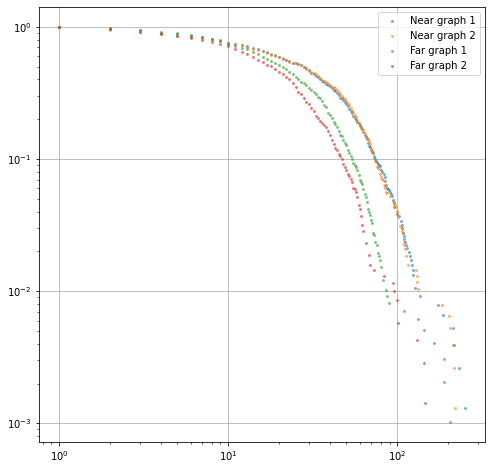

In [27]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_degree_ccdf(G, label):
    # Get the degree of each node
    degree_sequence = [d for n, d in G.degree()]
    # Perform linear binning
    degree_counts = Counter(degree_sequence)
    deg, cnt = zip(*sorted(degree_counts.items()))
    deg, cnt = np.array(deg), np.array(cnt)
    prob = cnt / sum(cnt)
    # Complementary Cumulative Distribution Function
    loglog_args = {'ls': '', 'marker': 'o', 'markersize': 2, 'alpha': 0.5}
    ccdf = np.cumsum(prob[::-1])[::-1]
    plt.loglog(deg, ccdf, label=label, **loglog_args)

graphs = {
    'Near graph 1': Gn1, 
    'Near graph 2': Gn2, 
    'Far graph 1': Gf1, 
    'Far graph 2': Gf2,
}
fig = plt.figure(figsize=(8,8))
for name, G in graphs.items():
    plot_degree_ccdf(G, name)
plt.legend()
plt.grid()

# Correlations between node attributes

In [50]:
shared_edges_near = sorted(set(Gn1.edges()).intersection(Gn2.edges))
shared_edges_far = sorted(set(Gf1.edges()).intersection(Gf2.edges))

def get_edge_attr(G, shared_edges, name):
    attr_dict = nx.get_edge_attributes(G, name)
    return [attr_dict[e] for e in shared_edges]

n_fibers_near1 = get_edge_attr(Gn1, shared_edges_near, 'number_of_fibers')
n_fibers_near2 = get_edge_attr(Gn2, shared_edges_near, 'number_of_fibers')
n_fibers_far1 = get_edge_attr(Gf1, shared_edges_far, 'number_of_fibers')
n_fibers_far2 = get_edge_attr(Gf2, shared_edges_far, 'number_of_fibers')

(-50.0, 2000.0)

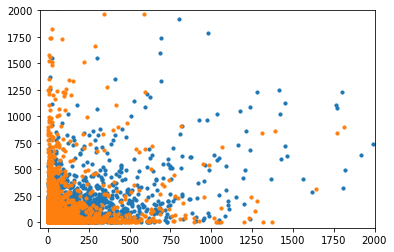

In [51]:
plt.scatter(n_fibers_near1, n_fibers_near2, s=10)
plt.scatter(n_fibers_far1, n_fibers_far2, s=10)
plt.xlim(-50, 2000)
plt.ylim(-50, 2000)

In [53]:
from scipy.stats import pearsonr
r_near, _ = pearsonr(n_fibers_near1, n_fibers_near2)
r_far, _ = pearsonr(n_fibers_far1, n_fibers_far2)
print(f"Pearson's R for edge fiber count - Near: {r_near:.4} Far: {r_far:.4}")

Pearson's R for edge fiber count - Near: 0.6277 Far: 0.1258


# Distribution of clustering coefficients

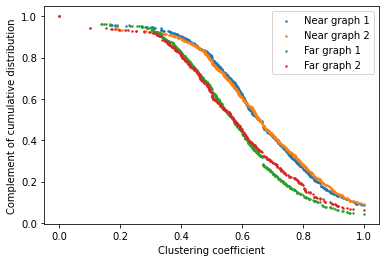

In [54]:
def plot_ccoeff_ccdf(G, label=''):
    data = sorted(nx.clustering(G).values())
    counts = Counter(data)
    ccoeffs, counts = zip(*sorted(counts.items()))
    ccoeffs, counts = np.array(ccoeffs), np.array(counts)
    probs = counts / sum(counts)
    ccdf = np.cumsum(probs[::-1])[::-1]
    plt.scatter(ccoeffs, ccdf, s=2, label=label)

for name, G in graphs.items():
    plot_ccoeff_ccdf(G, label=name)
plt.legend()
plt.xlabel('Clustering coefficient')
_ = plt.ylabel('Complement of cumulative distribution')

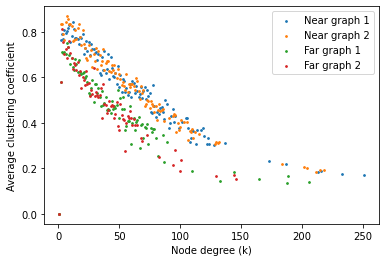

In [55]:
def plot_ccoeff_vs_degree(graph, label=None):
    nodes = graph.nodes()
    ccoeffs = nx.clustering(graph)
    ccoeffs = np.array([ccoeffs[n] for n in nodes])
    degrees = nx.degree(graph)
    degrees = np.array([degrees[n] for n in nodes])
    unique_degrees = sorted(np.unique(degrees))
    mean_coeffs = []
    for k in unique_degrees:
        mean_coeffs.append(np.average(ccoeffs[np.where(degrees==k)]))
    plt.scatter(unique_degrees, mean_coeffs, s=3, label=label)

for name, G in graphs.items():
    plot_ccoeff_vs_degree(G, label=name)
plt.legend()
plt.xlabel('Node degree (k)')
_ = plt.ylabel('Average clustering coefficient')

# Centrality

In [63]:
def get_ordered_betweenness(G, shared_nodes):
    betweenness = nx.betweenness_centrality(G, weight='number_of_fibers')
    ordered = [betweenness[n] for n in shared_nodes]
    return ordered

shared_nodes_near = sorted(set(Gn1.nodes()).intersection(Gn2.nodes))
shared_nodes_far = sorted(set(Gf1.nodes()).intersection(Gf2.nodes))

btwn_near1 = get_ordered_betweenness(Gn1, shared_nodes_near)
btwn_near2 = get_ordered_betweenness(Gn2, shared_nodes_near)
btwn_far1 = get_ordered_betweenness(Gf1, shared_nodes_far)
btwn_far2 = get_ordered_betweenness(Gf2, shared_nodes_far)

(-0.001, 0.05)

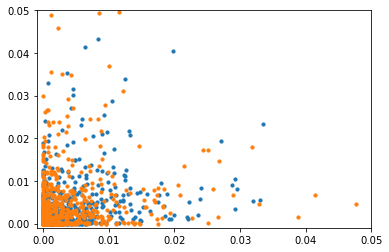

In [65]:
plt.scatter(btwn_near1, btwn_near2, s=10)
plt.scatter(btwn_far1, btwn_far2, s=10)
plt.xlim(-0.001, 0.05)
plt.ylim(-0.001, 0.05)

In [66]:
from scipy.stats import pearsonr
r_near, _ = pearsonr(btwn_near1, btwn_near2)
r_far, _ = pearsonr(btwn_far1, btwn_far2)
print(f"Pearson's R for edge fiber count - Near: {r_near:.4} Far: {r_far:.4}")

Pearson's R for edge fiber count - Near: 0.5577 Far: 0.2985


# Plotting graphs for visual inspection

In [14]:
def load_graph(fpath):
    G = nx.read_graphml(fpath)
#     G = nx.convert_node_labels_to_integers(G)
#     G.remove_nodes_from(list(nx.isolates(G)))
    return G

# Load the most similar and most different pairs of graphs
Gn1 = load_graph(graph_filenames[NEAR_PAIR[0]])
Gn2 = load_graph(graph_filenames[NEAR_PAIR[1]])
Gf1 = load_graph(graph_filenames[FAR_PAIR[0]])
Gf2 = load_graph(graph_filenames[FAR_PAIR[1]])

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

plt.rcParams.update({'font.size': 14})

def get_node_pos(G, dim):
    pos = nx.get_node_attributes(G, f'dn_position_{dim}')
    ordered = [pos[n] for n in G.nodes()]
    return ordered

def get_attribute_color(G, attr):
    attrs = nx.get_node_attributes(G, attr)
    cats = sorted(set(attrs.values()))
    cat2val = dict(zip(cats, np.linspace(0, 1, len(cats))))
    vals = [cat2val[attrs[n]] for n in G.nodes()]
    return vals

def plot_brain_graphs(graphs):
#     graphs = utils.get_brain_graphs(2)
    titles = ['Horizontal plane', 'Coronal plane', 'Sagittal plane']
    dims = [('y', 'x'), ('x', 'z'), ('y', 'z')]
    fig, all_axes = plt.subplots(len(graphs), 3, figsize=(16,10), sharex='col', sharey='col')
    for i, (G, axis_subset) in enumerate(zip(graphs, all_axes)):
#         node_colors = get_attribute_color(G, 'dn_hemisphere')
        cc = nx.closeness_centrality(G, distance='fiber_length_mean')
        node_colors = [cc[n] for n in G.nodes]
        for title, dim_labels, ax in zip(titles, dims, axis_subset):
            dim1, dim2 = dim_labels
            all_pos1 = get_node_pos(G, dim1)
            all_pos2 = get_node_pos(G, dim2)
            node_pos = {n: (pos1, pos2) for n, pos1, pos2 in zip(G.nodes, all_pos1, all_pos2)}
            nx.draw(G, node_color=node_colors, pos=node_pos, node_size=10, width=0.05, ax=ax, cmap=plt.cm.viridis)
            if i == 0:
                ax.set_title(title)
            ax.set_aspect('equal')
            ax.axis('off')
    plt.tight_layout()

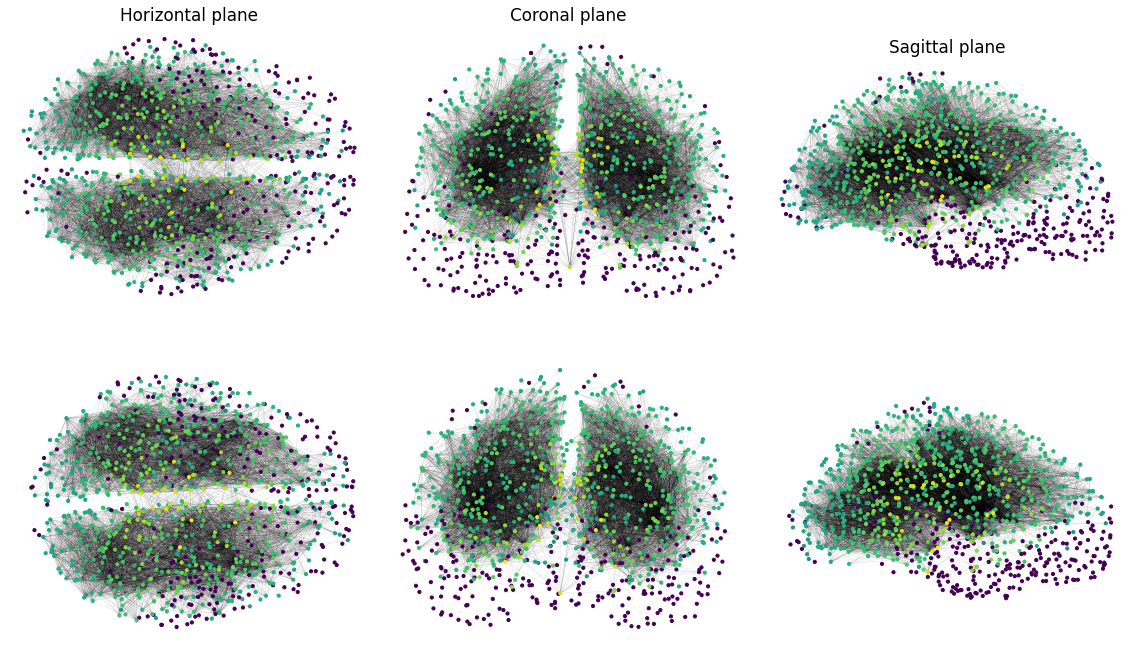

In [30]:
plot_brain_graphs([Gn1, Gn2])

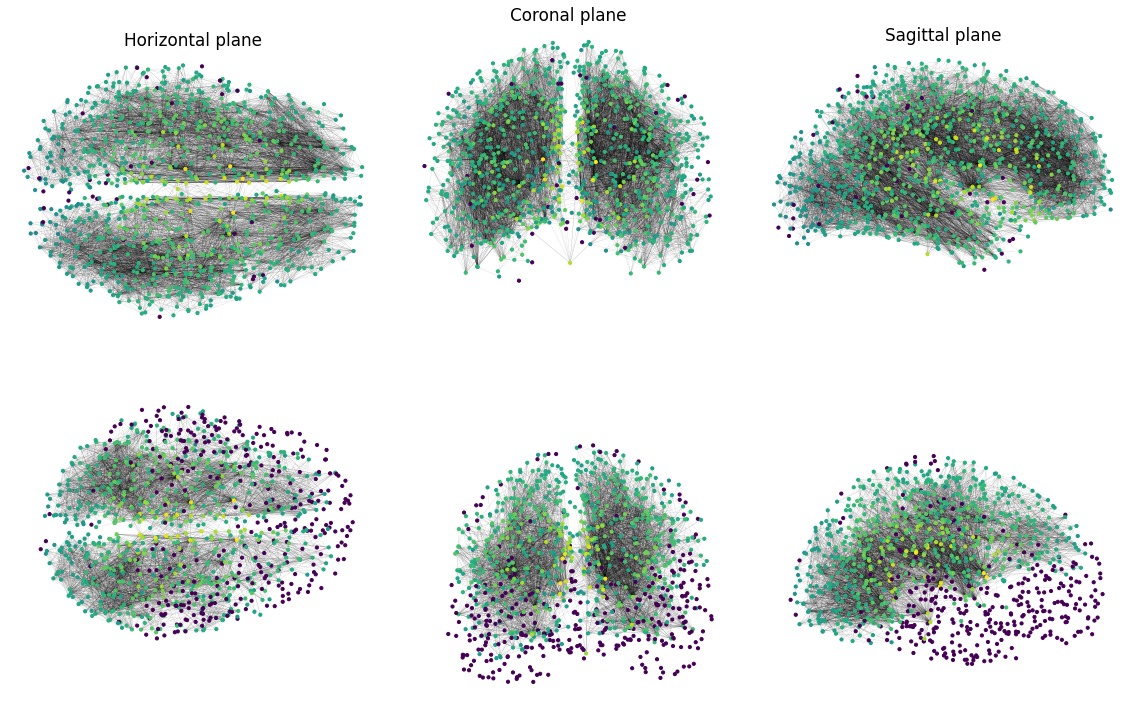

In [31]:
plot_brain_graphs([Gf1, Gf2])